In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.gp import SVGP, VNNGP, GaussianPrior
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2, Hybrid_NSF2
import squidpy as sq
import numpy as np
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf, add_jitter, dims_autocorr
import gpzoo.pri_experiment_utilities as putil
import time
import scanpy as sc
import random
from os import path
from math import ceil
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
from sklearn.cluster import KMeans
from scipy.stats import poisson
from scipy.sparse import issparse
from sklearn.decomposition import NMF

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
2024-08-01 07:46:42.855082: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 07:46:42.868792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been regist

In [2]:
random.seed(256)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
dtp = "float32"
root_path = '/engelhardt/home/pshrestha/vnngp'
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
slideseq_pth = path.join(rpth, "slideseq/")

In [4]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
            
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [5]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

def deviance_feature_selection(Y, fam="poisson"):
    if issparse(Y):
        Y = Y.toarray()
    feature_sums = Y.sum(axis=0)
    sz = Y.sum(axis=1)
    deviance = np.zeros(Y.shape[1])
    for i in range(Y.shape[1]):
        if feature_sums[i] == 0:
            continue
        if fam == "poisson":
            with np.errstate(divide='raise'):
                try:
                    ll_null = feature_sums[i] * np.log(feature_sums[i] / sz.sum())
                    ll_alt = Y[:, i] * np.log(Y[:, i] / sz) - Y[:, i] + ll_null
                    deviance[i] = 2 * (ll_alt.sum() - ll_null)
                except FloatingPointError:
                    deviance[i] = 0
    return deviance

In [6]:
#X, Y = putil.load_slideseq()

In [7]:
#print(X.shape)
#print(Y.shape)

In [8]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


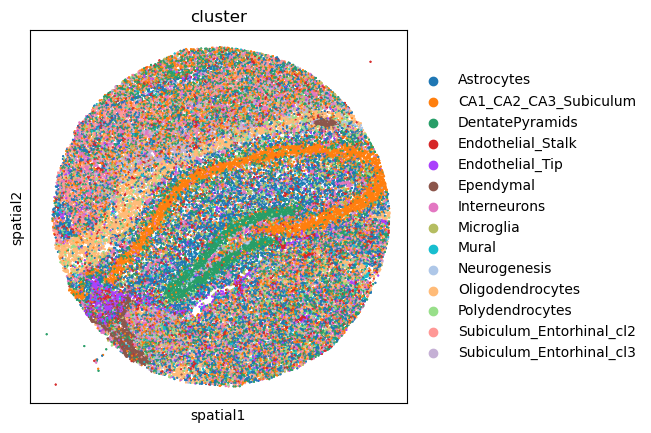

In [9]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);

<Axes: >

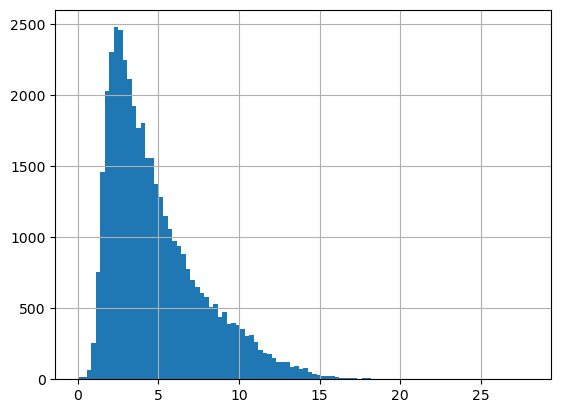

In [10]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)

In [11]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [12]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [13]:
Y.shape

(17702, 39694)

In [14]:
nmf_model = NMF(n_components=12, max_iter=100, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [15]:
nmf_model.fit(Y.T/V)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=100, n_components=12,
    random_state=0)

In [16]:
exp_factors = nmf_model.transform(Y.T/V)/5
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T*5

In [17]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

In [18]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [19]:
((factors_ordered.T[:12]).T).shape

(39694, 12)

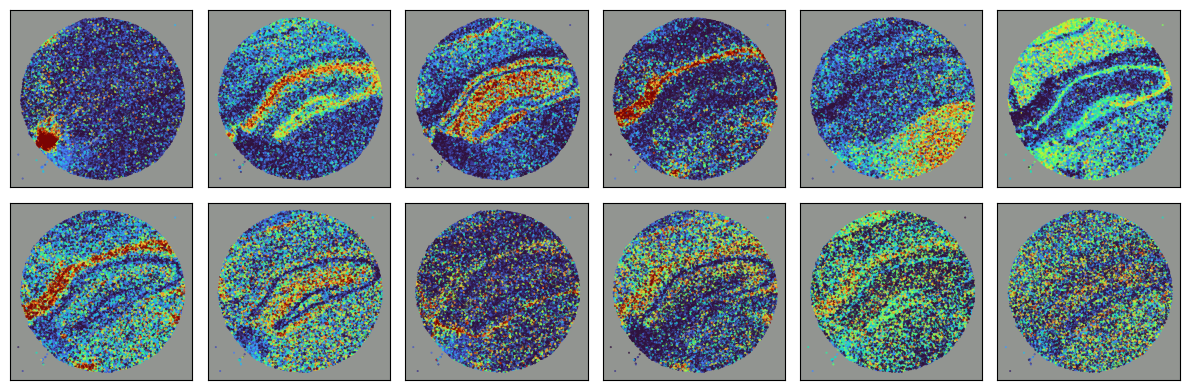

In [20]:
plot_factors(np.exp(factors_ordered.T)[:12], X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [ ]:
#zero out repeated factors
factors_ordered[:,5]=np.random.randn(*factors_ordered[:,5].shape)
factors_ordered[:,8]=np.random.randn(*factors_ordered[:,8].shape)
factors_ordered[:,9]=np.random.randn(*factors_ordered[:,9].shape)
factors_ordered[:,12]=np.random.randn(*factors_ordered[:,9].shape)
factors_ordered[:,15]=np.random.randn(*factors_ordered[:,9].shape)

loadings_ordered[:,5][::1]=0.0
loadings_ordered[:,8][::1]=0.0
loadings_ordered[:,9][::1]=0.0
loadings_ordered[:,12][::1]=0.0
loadings_ordered[:,15][::1]=0.0

factors=factors_ordered
loadings=loadings_ordered

In [21]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

### NMF Initialization [OLD]

In [22]:
L = [10]
max_iter = 20000

for l in L:
    start = time.time()
    Y_train = torch.tensor(Y).to(device)
    factors, loadings = regularized_nmf(Y.T, L=l, max_iter = max_iter, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=256)
    end = time.time()
    total_time = end - start

    factors = torch.tensor(factors)
    loadings = torch.tensor(loadings)

    nmf_slideseq_save_pth = path.join(slideseq_pth, f"nmf/nmf_factors_iter={max_iter}_rs=256_L={l}.pt")
    torch.save({'factors': factors, 'loadings': loadings, 'time': total_time}, nmf_slideseq_save_pth)
    print("Done")

/tmp/ipykernel_1454344/1273875473.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y).to(device)


KeyboardInterrupt: 

In [ ]:
factors.shape

In [ ]:
print(X.shape)
print(Y.shape)

In [ ]:
X_array = np.array(X)
Y_array = np.array(Y)
factors = np.array(factors)
moran_idx, moranI = putil.dims_autocorr(factors, X)

In [ ]:
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
putil.plot_factors(np.exp(factors.T), X, moran_idx=moran_idx, size=2, s=1.0, alpha=0.9, ax=axes)

### Runs

### NMF Initialization [NEW]

In [ ]:
nmf_model = NMF(n_components=15, max_iter=10, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7)

In [ ]:
(Y.T).shape

In [ ]:
nmf_model.fit(Y.T)

In [ ]:
exp_factors = nmf_model.transform(Y.T)/5
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T*5

In [ ]:
print(factors.shape)

In [ ]:
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), X)

In [ ]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [ ]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [ ]:
##### Check initialization
size=2
fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
plot_factors(np.exp(factors_ordered.T), X, moran_idx=None, size=2, s=0.2, alpha=0.9, ax=axes)

In [ ]:
#zero out repeated factors
#factors_ordered[:,4]=np.random.randn(*factors_ordered[:,4].shape)
#factors_ordered[:,8]=np.random.randn(*factors_ordered[:,8].shape)
#factors_ordered[:,9]=np.random.randn(*factors_ordered[:,9].shape)
#factors_ordered[:,12]=np.random.randn(*factors_ordered[:,9].shape)
#factors_ordered[:,15]=np.random.randn(*factors_ordered[:,9].shape)
#loadings_ordered[:,4][::1]=0.0
#loadings_ordered[:,8][::1]=0.0
#loadings_ordered[:,9][::1]=0.0
#loadings_ordered[:,12][::1]=0.0
#loadings_ordered[:,15][::1]=0.0

In [ ]:
factors=factors_ordered
loadings=loadings_ordered

In [ ]:
print(factors.shape)

In [ ]:
print(loadings.shape)

## NNNSF

In [42]:
#L = [10, 15, 5, 8, 12]
L = [12]
#M = [500, 1000, 2000, 3000, 5000]
M = [3000]
#K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#K = [1, 5, 10, 20]
K = [8]
lkzz_builds = [1]
#sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sigmas = [1.0]
#sigmas = [10.0]
#lengthscales = [1.2, 1.5, 2.0]
lengthscales = [3.0, 4.0]

In [43]:
model_type = 'VNNGP'
steps = 5000
batched = True
NMF = True

In [44]:
print(sigmas)
print(lengthscales)

[1.0]
[3.0, 4.0]


In [45]:
#loadings_sf = torch.nn.functional.softplus(model.W).detach().cpu()
#loadings_cf = torch.nn.functional.softplus(model.W).detach().cpu()

In [46]:
#plt.hist(torch.log(loadings_sf.view(-1)), bins=100);
#plt.hist(torch.log(loadings_cf.view(-1)), bins=100);

In [47]:
save_path = path.join(root_path, "results/slideseq/nnnsf")

In [48]:
def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    V = scanpy_sizefactors(Y.T)
    #X = torch.tensor(X).type(torch.float).to(device)
    #Y = torch.tensor(Y).type(torch.float).to(device)
    kwargs = kwargs['kwargs']

    kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z.to('cpu'), X.to('cpu'))
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    #print(Kzx @ Kxz)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-2)) # changed from 1e-4 to 1e-3
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp=gp, y=Y, L=kwargs['L'])

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))
    model.to(device)
    return model

Shape of factors is:  (39694, 12)
Shape of X_array is:  (39694, 2)


/tmp/ipykernel_1465618/382415143.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/tmp/ipykernel_1465618/382415143.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y).type(torch.float)
/tmp/ipykernel_1465618/382415143.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).to(device)
/tmp/ipykernel_1465618/382415143.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

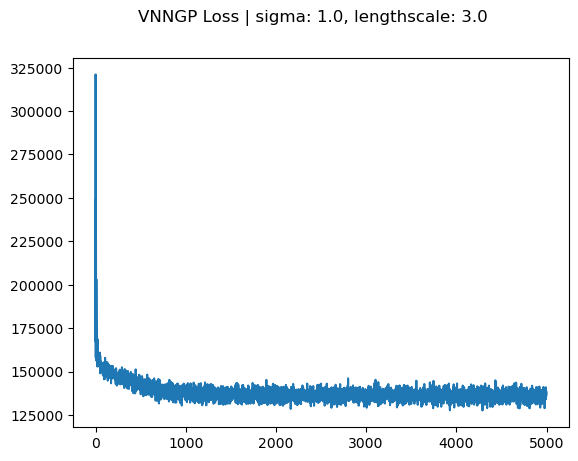

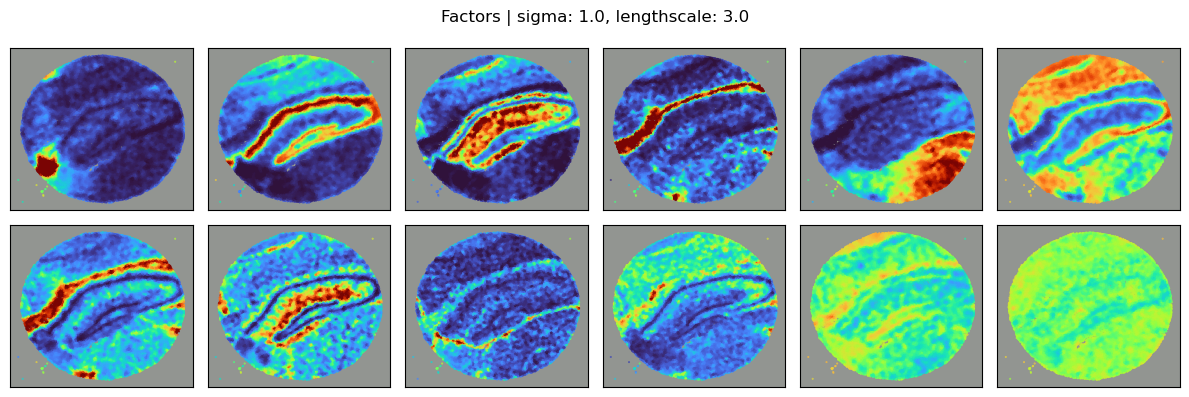

Shape of factors is:  (39694, 12)
Shape of X_array is:  (39694, 2)


/tmp/ipykernel_1465618/382415143.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/tmp/ipykernel_1465618/382415143.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y).type(torch.float)
/tmp/ipykernel_1465618/382415143.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).to(device)
/tmp/ipykernel_1465618/382415143.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

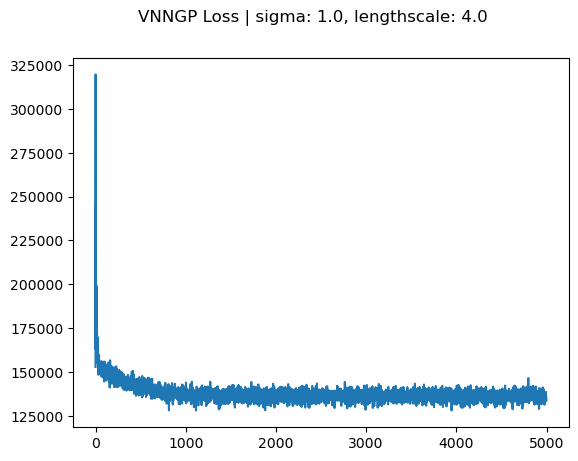

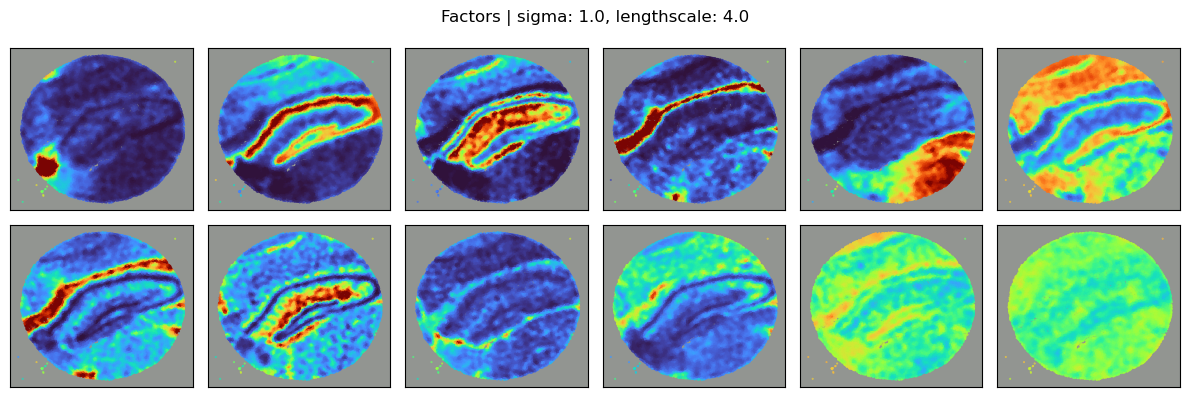

In [49]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 12, 
                'M': 3000, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-2,
                'batch_size': 128,
                'lr': 1e-3,
                'rs': 256,
                'lkzz_build': 1,
            }
            
            factors = np.array(((factors_ordered.T[:12]).T))
            loadings = np.array((loadings_ordered.T[:12]).T)
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
                
            if NMF:
                # with NMF initialization
                file_path += f"_NMFinit"
                X_array = np.array(X.cpu())
                Y_array = np.array(Y.cpu())
                print("Shape of factors is: ", factors.shape)
                print("Shape of X_array is: ", X_array.shape)
                #moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                #factors=factors[:, moran_idx]
                #loadings=loadings[:, moran_idx]
                model = build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                    
            #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            X = torch.tensor(X).type(torch.float)
            Y = torch.tensor(Y).type(torch.float)
            X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X_train, Y, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            end_time = time.time()
                
            final_time = end_time - start_time
                
            #torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            #torch.save({'losses': losses,
                        #'means': means,
                        #'scales': scales,
                        #'time': final_time},
                         #f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            size=2
            fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            #plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=0.2, alpha=0.9, ax=axes)
            plot_factors(mean, X.cpu().detach().numpy(), moran_idx=None, ax=ax, size=2, s=0.2, alpha=0.9)
            fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

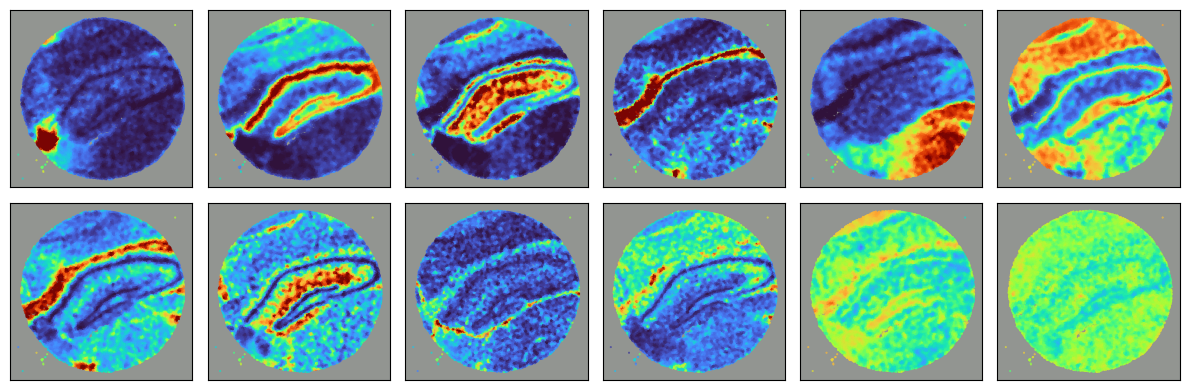

In [38]:
plot_factors(mean, X.cpu().detach().numpy(), moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

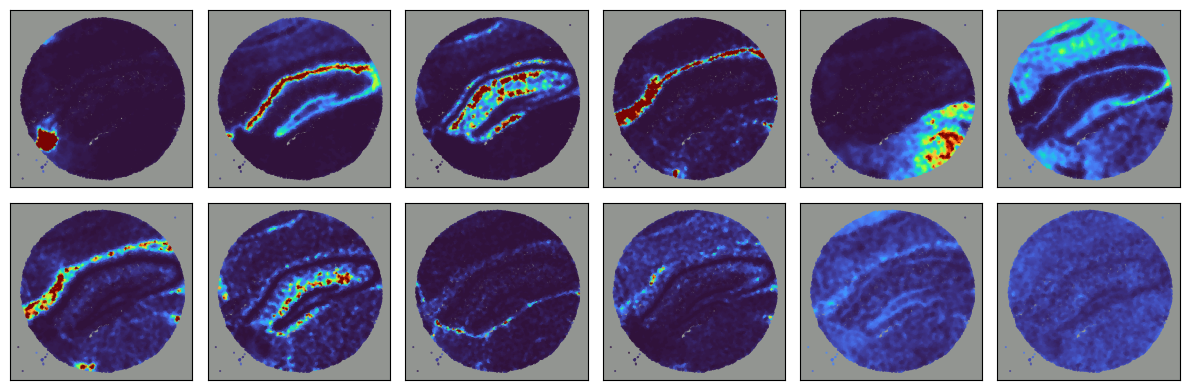

In [39]:
plot_factors(np.exp(np.exp(mean)), X.cpu().detach().numpy(), moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(size*7, size*1.5), tight_layout=True)
plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=0.01, alpha=0.9, ax=axes)

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
putil.plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=0.9, ax=axes)
fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
fig.savefig(f'{save_path}/{file_path}_plot.png')

In [ ]:
max_iter = 20000
nmf_results = torch.load(f'/engelhardt/home/pshrestha/vnngp/results/slideseq/nmf/nmf_factors_iter={max_iter}_rs=256_L=10.pt')
factors = np.array(nmf_results['factors'])
loadings = np.array(nmf_results['loadings'])